# Estimating Correlation Using Discrete Copulas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

from scipy.stats import truncnorm, poisson, norm, nbinom, multivariate_normal
import scipy.stats as stats

import tools as tl

# load data
data1_4 = pd.read_csv("mt-datasets/Donor1_CD4_Genes.csv")
# normalization
data_norm = tl.RPM(data1_4)
fitted_para = pd.read_csv('fitted_data/fitted_para.csv')

data_pro = data_norm[fitted_para.columns.to_list()]
data_pro = data_pro.reset_index(drop=True)
N = data_pro.shape[0]

Gaussian Copula

In [42]:
def cdgaussian_copulas(u, ranges, rho):
    '''inv2 = norm.ppf(u)
    a, b = range
    inv_a = norm.ppf(a)
    inv_b = norm.ppf(b)
    mu = inv2*rho
    sigma = np.sqrt(1-rho ** 2)
    inv1 = truncnorm.rvs((inv_a-mu) / sigma, (inv_b-mu) /
                         sigma, loc=inv2*rho, scale=sigma)
    val = norm.cdf(inv1)'''
    u = np.asarray(u)
    
    # Compute inverse CDF (norm.ppf) for u
    inv2 = norm.ppf(u)
    
    # Extract lower and upper bounds from the ranges matrix
    a = [lis[0] for lis in ranges]
    b = [lis[1] for lis in ranges]
    
    # Compute inverse CDF for the ranges
    inv_a = norm.ppf(a)
    inv_b = norm.ppf(b)
   
    # Compute mu and sigma for the truncated normal distribution
    mu = inv2 * rho
    sigma = np.sqrt(1 - rho ** 2)
    #print(1)

    lower_bounds = (inv_a - mu) / sigma
    #lower_bounds = np.maximum(0, lower_bounds)
    upper_bounds = (inv_b - mu) / sigma
    #print(lower_bounds.shape,upper_bounds.shape,sigma,len(mu),len(u))
    dif_indices = [i for i in range(len(lower_bounds)) if lower_bounds[i]!=upper_bounds[i]]
    inv1 = truncnorm.rvs(lower_bounds[dif_indices], upper_bounds[dif_indices], loc=mu[dif_indices], scale=sigma, size=len(dif_indices))
    
    if len(dif_indices)!=len(lower_bounds):
        res = lower_bounds
        for i in range(len(inv1)):
            res[dif_indices[i]]=inv1[i]
        inv1 = res

    #print(3)
    # Compute the cumulative distribution function (CDF) of the generated samples
    val = norm.cdf(inv1)
    
    return val
cdgaussian_copulas([0.5,0.4], [[0.4,0.7],[0.2,0.8]], 0.5)

array([0.67342446, 0.77221693])

In [3]:
def zinb_cdf(k, para):
    """
    Calculate the CDF of the Zero-Inflated Negative Binomial (ZINB) distribution.

    Returns:
    cdf : float
        The cumulative probability of the ZINB distribution at k.
    """
    # CDF of the Negative Binomial distribution
    mu, r, p_zero = para
    p = 1 - mu / (mu+r)
    nb_cdf = stats.nbinom.cdf(k, r, p)

    return 1-p_zero + p_zero * nb_cdf

In [4]:
def get_range(data, para):
    N = data.shape[0]
    data_range = pd.DataFrame(index=range(N), columns=data.columns.to_list())
    for col in data.columns:
        para_0 = para[col]
        if not pd.isna(para_0[2]):
            for i in range(N):
                x = data_pro[col][i]
                data_range.loc[i, col] = [x, zinb_cdf(
                    x-1, para_0), zinb_cdf(x, para_0)]
        else:
            for i in range(N):
                x = data_pro[col][i]
                data_range.loc[i, col] = [x, stats.nbinom.cdf(
                    x-1, para_0[0], para_0[1]), stats.nbinom.cdf(x, para_0[0], para_0[1])]
    return data_range

data_range=get_range(data_pro, fitted_para)

In [5]:
def truncnorm_prop_rho(x, sigma):  # proposal for rho (non-negative)
    return truncnorm.rvs((-1-x) / sigma, (1-x) / sigma, loc=x, scale=sigma)

def truncnorm_rho_pdf(x,x_p,sigma):
    rv = truncnorm((-1-x) / sigma, (1-x) / sigma, loc=x, scale=sigma)
    return rv.pdf(x_p)
def set_initial(data):
    N = data.shape[0]
    data_initial = pd.DataFrame(index=range(N), columns=data.columns.to_list())
    for col in data.columns:
        for i in range(N):
            data_initial.loc[i,col] = [random.uniform(
                data[col][i][1], data[col][i][2])]
            data_initial.loc[i,col]+=data[col][i][1:]
    return data_initial

initial_u = set_initial(data_range)

In [6]:
def update_u(u1_initial, u2_pack, rho):
    N = u1_initial.shape[0]
    col2 = u2_pack.columns
   
    u2 = pd.DataFrame(index=range(N), columns=col2.to_list())
    u_condition = [u1_initial[u1_initial.columns[0]][i][0] for i in range(N)]
    ranges = [u2_pack[col2[0]][i][1:] for i in range(N)]

    new_val = cdgaussian_copulas(u_condition,ranges,rho)
    u2[col2[0]] = [[new_val[i],u2_pack[col2[0]][i][1],u2_pack[col2[0]][i][2]] for i in range(N)]
    
    return u2

## MH for rho

In [99]:
def log_gcopula_cdf(u1,u2,rho):
    mean = [0,0]
    cov = [[1,rho],[rho,1]]
    '''rv = multivariate_normal(mean,cov)
    return np.log(rv.pdf([norm.ppf(u1),norm.ppf(u2)]))'''
    inv_u1 = norm.ppf(u1)
    inv_u2 = norm.ppf(u2)

    # Create a multivariate normal distribution object
    rv = multivariate_normal(mean, cov)
    
    # Combine inv_u1 and inv_u2 into a 2D array for vectorized evaluation
    inv_uv = np.column_stack((inv_u1, inv_u2))
    
    # Calculate the log of the PDF values for all pairs in inv_uv
    log_cdf_vals = rv.logcdf(inv_uv)

    return log_cdf_vals

def log_gcopula_pdf(u1,u2,rho):
    q1 = norm.ppf(u1)
    q2 = norm.ppf(u2)
    
    # Compute the log of the bivariate normal PDF
    term1 = -0.5 * np.log(1 - rho**2)
    term2 = -0.5 / (1 - rho**2) * (q1**2 + q2**2 - 2 * rho * q1 * q2)
    
    log_pdf = term1 + term2
    
    return log_pdf
    
def gc_acceptance_ratio(u, u_p,rho_vals):
    rho,rho_p = rho_vals
    u1,u2 = u
    u1_p,u2_p = u_p

    u1 = u1.to_numpy()
    u2 = u2.to_numpy()
    u1_p= u1_p.to_numpy()
    u2_p = u2_p.to_numpy()
    u1 = [li[0][0] for li in u1]
    u2 = [li[0][0] for li in u2]
    u1_p = [li[0][0] for li in u1_p]
    u2_p = [li[0][0] for li in u2_p]
    
    acc =sum(log_gcopula_pdf(u1_p,u2_p,rho_p))-sum(log_gcopula_pdf(u1,u2,rho))
    return acc
#gc_acceptance_ratio(initial_u[['MT-CO1']],initial_u[['MT-CO2']],(0.4,0.5))


In [10]:

def negative_binomial_marginal(num,r, p, u_raw):
   
    N, J = num.shape

    rtn = [np.zeros((N, J)), np.zeros((N, J))]
    
    for j in range(J):
        for n in range(N):
            
            Ubound = nbinom.cdf(num[n, j],r[j] , p[j])
            Lbound = 0
            if num[n, j] > 0:
                Lbound = nbinom.cdf(num[n, j] - 1, r[j], p[j])
            UmL = Ubound - Lbound
            rtn[0][n, j] = norm.ppf(Lbound + UmL * u_raw[n, j])
            rtn[1][n, j] = np.log(UmL)
    
    return rtn
def apply_ng_marginal(name1,name2,u):
    num = data_pro[[name1,name2]].values
    r = fitted_para.loc[0,[name1,name2]].values
    p = fitted_para.loc[1,[name1,name2]].values
    u_raw = u
    return negative_binomial_marginal(num,r, p, u_raw)

In [106]:
def metropolis_hastings_gc(u1, u2, sigma, n_iter=10000, burn_in=2000, thin=5):

    trace = np.zeros(n_iter)
    trace[0] = 0

    acceptance_rate = np.zeros(n_iter)
    rho = trace[0]

    for i in range(1, n_iter):
        rho = trace[i-1]
        rho_p = truncnorm_prop_rho(rho, sigma)

        u1_p = update_u(u2, u1, rho_p)
        u2_p = update_u(u1, u2, rho_p)

        alpha = gc_acceptance_ratio(
            (u1, u2), (u1_p, u2_p), (rho, rho_p))
        u = np.log(np.random.uniform(0., 1.))
        #print(alpha)
        if u < alpha:
            trace[i] = rho_p
            acceptance_rate[i-1] = 1
            u1 = u1_p
            u2 = u2_p
        else:
            trace[i] = rho
    print(u1.columns[0]+' and '+u2.columns[0]+" acceptance rate is: %.2f" % acceptance_rate[burn_in:].mean())
    return pd.DataFrame(trace[burn_in::thin])

trace_0 = metropolis_hastings_gc(initial_u[['MT-CO1']], initial_u[['MT-CO2']], sigma=0.01, n_iter=100, burn_in=1, thin=1)

MT-CO1 and MT-CO2 acceptance rate is: 0.55


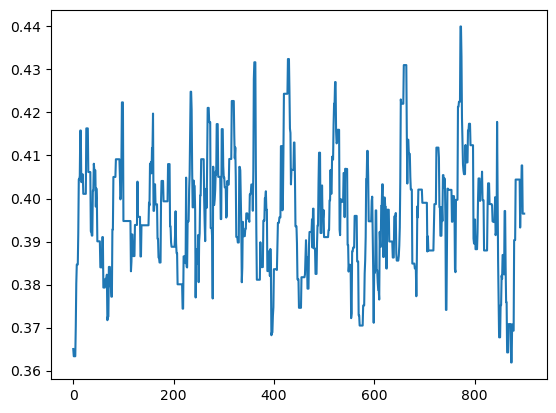

In [101]:
plt.plot(trace_0[0])

In [103]:
cor_o = np.zeros((13,13))

In [107]:
names = data_range.columns.to_list()
traces = pd.DataFrame(index=names, columns=names)
for i in range(13):
    for j in range(i+1,13):
        tra = metropolis_hastings_gc(initial_u[[names[i]]], initial_u[[names[j]]], sigma=0.01, n_iter=1000, burn_in=500, thin=2)
        traces.loc[names[i],names[j]]= [tra[:100].mean()-tra[-100:].mean(),tra,tra.mean()]
        cor_o[i,j]=float(tra.mean().iloc[0])
        print(cor_o[i,j])
print(cor_o)


MT-CO1 and MT-CO2 acceptance rate is: 0.44
0.40330789778959464
MT-CO1 and MT-CO3 acceptance rate is: 0.50
0.41176342690710055
MT-CO1 and MT-CYB acceptance rate is: 0.37
0.2743730138394319
MT-CO1 and MT-ND1 acceptance rate is: 0.50
0.10367046366822937
MT-CO1 and MT-ND2 acceptance rate is: 0.49
0.14068899585640304
MT-CO1 and MT-ND3 acceptance rate is: 0.48
0.23102331007377327
MT-CO1 and MT-ND4 acceptance rate is: 0.44
0.18198031220612426
MT-CO1 and MT-ND4L acceptance rate is: 0.51
0.1947547110315308
MT-CO1 and MT-ND5 acceptance rate is: 0.44
0.16418201589109627
MT-CO1 and MT-ND6 acceptance rate is: 0.44
0.06664430033743056
MT-CO1 and MT-ATP6 acceptance rate is: 0.48
0.11996401730355896
MT-CO1 and MT-ATP8 acceptance rate is: 0.45
0.17964354138977445
MT-CO2 and MT-CO3 acceptance rate is: 0.74
0.5539253443967286
MT-CO2 and MT-CYB acceptance rate is: 0.55
0.613169524736381
MT-CO2 and MT-ND1 acceptance rate is: 0.82
0.2644950173444432
MT-CO2 and MT-ND2 acceptance rate is: 0.83
0.3172984668528

In [479]:
cor_o

array([[0.        , 0.39741343, 0.41019837, 0.27086932, 0.10789021,
        0.13394734, 0.22795239, 0.17879711, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.     

In [16]:
initial_u['MT-ND4L']

0       [0.7765976606673753, 0.7765888533402772, 0.776...
1       [0.8777996237293738, 0.8777934052794714, 0.877...
2       [0.9067279138681467, 0.906723572709358, 0.9067...
3       [0.47469328145721, 0.47468189932979404, 0.4746...
4       [0.6077746147681284, 0.6077718169593974, 0.607...
                              ...                        
2882    [0.3717499383414894, 0.3717351652277573, 0.371...
2883    [0.9602667038596266, 0.9602652643560052, 0.960...
2884    [0.2749743587322226, 0.27497400131132765, 0.27...
2885    [0.6221022351052189, 0.6220990421804956, 0.622...
2886    [0.27497893322780304, 0.27497400131132765, 0.2...
Name: MT-ND4L, Length: 2887, dtype: object

In [94]:
names = data_pro.columns.to_list()
def copulas_val(u1,u2,rho):
    mean = [0,0]
    cov = [[1,rho],[rho,1]]
    '''rv = multivariate_normal(mean,cov)
    return np.log(rv.pdf([norm.ppf(u1),norm.ppf(u2)]))'''
    inv_u1 = norm.ppf(u1)
    inv_u2 = norm.ppf(u2)

    # Create a multivariate normal distribution object
    rv = multivariate_normal(mean, cov)
    
    # Combine inv_u1 and inv_u2 into a 2D array for vectorized evaluation
    inv_uv = np.column_stack((inv_u1, inv_u2))
    
    # Calculate the log of the PDF values for all pairs in inv_uv
    pdf_vals = rv.cdf(inv_uv)
    
    return pdf_vals
def kendalls_tau(name1, name2):
    tau = 0
    
    rho = 0.55464423
    x1 = data_range[name1]
    x2 = data_range[name2]
    
    for val1 in x1:
        print(tau)
        for val2 in x2:
            f = sum(copulas_val([val1[2], val1[1]], [val2[2], val2[1]], rho))-sum(copulas_val([val1[1], val1[2]],
                                                                                              [val2[2], val2[1]], rho))
            
            term2 = sum(copulas_val([val1[2], val1[1], val1[2], val1[1]], [
                val2[2], val2[1], val2[1], val2[2]], rho))
            print(f,term2)
            tau += f*term2
    tau -= 1
    return tau
kendalls_tau('MT-CO2', 'MT-CO3')

0
9.155431968110861e-11 2.863141568618172
4.269917752708352e-12 3.21642841984841
4.3298697960381105e-15 1.1672971729751902
1.1213252548714081e-14 1.2563105497569333
0.0 0.12943041492602098
2.8924196371349353e-11 2.4714858166624056
0.0 0.0005952994663513159
2.7755575615628914e-17 0.4453621212588256
1.3538059562279159e-12 1.8548343855008884
1.4560574967958928e-11 2.302757604927936
8.162759357333016e-11 3.1660225812441256
5.8610893916011264e-12 2.1118110529204
9.529133038199689e-11 2.8838730018968657
1.5638601524869955e-11 2.319143127175501
1.6087131626818518e-11 2.3256908264677745
5.557776461273534e-12 2.101539273191395
1.4765966227514582e-13 3.217168807660534
1.1302669911117391e-10 3.0188139311464046
9.026934755240745e-11 3.152752343010352
1.010307393300991e-10 2.917511337270162
2.226263617899349e-11 3.210905632687618
3.3446578839857466e-12 2.0073026788627635
5.551115123125783e-17 0.8073825336720755
5.903944000351657e-11 2.685864664032077
3.113509450258789e-12 1.9945608887314445
1.57616

KeyboardInterrupt: 